#Прогин балки.

$\cfrac{d^4w}{dx^4}=\cfrac{q}{EI}$

##Защемлення


![picture](https://drive.google.com/uc?id=1tN6JMHRoUw5I3UGxmc1F5BGfmQnnUmYC)


Граничні умови

$w(0)=0,$
$\cfrac{dw}{dx}(0)=0$

Розв'язок

$w=-\cfrac{q}{24EI}\left( x^4 - 4Lx^3 + 6L^2x^2 \right)$

$w_{max}=\cfrac{-q_0L^4}{8EI}$


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
L = 2.0
q = 1.0
G = 2.77 * 10**4
nu = 0.3
E = 2*G*(1+nu)
h = 0.5
I = (h**4)/12
print(I)
print(E)
print(q/(E*I))
print(q/(E))

0.005208333333333333
72020.0
0.002665926131630103
1.3885031935573452e-05


In [ ]:
def w(x, q, E, I):
    return q/(24*E*I)*(x**4 - 4*L*x**3 + 6*L**2*x**2)

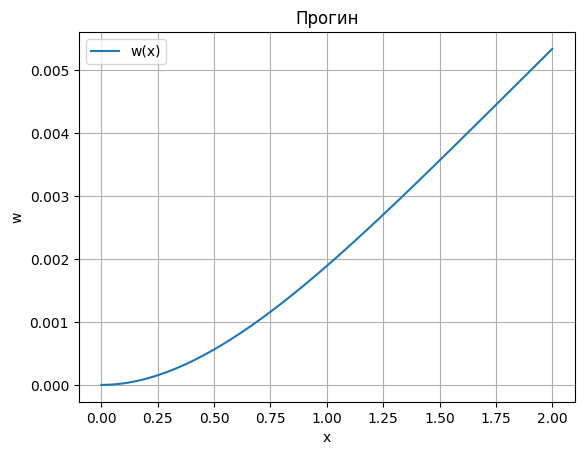

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Генерація значень x в діапазоні від -10 до 10
x_values = np.linspace(0, L, 100)

# Обчислення значень y за допомогою функції
y_values = w(x_values, q, E, I)

# Побудова графіка
plt.plot(x_values, y_values, label='w(x)')
plt.title('Прогин')
plt.xlabel('x')
plt.ylabel('w')
plt.legend()
plt.grid(True)
plt.show()


#Розв'язок за допомогою PINN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1,64),
            nn.Tanh(),
            # nn.Linear(64,64),
            # nn.Tanh(),
            # nn.Linear(64,64),
            # nn.ReLU(),
            nn.Linear(64,1),
            # nn.ReLU()
        )
        self.double()

    def forward(self, x):
        out = self.net(x)
        return out

In [ ]:
class Net:

    def __init__(self, num_iterations, num_points, q, L, E, I):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        print(device)
        self.device = device

        self.model = NN().to(device)

        self.x_max = L


        # comp. domain
        self.h = 0.01

        self.E = E
        self.q = q
        self.I = I

        self.epoch = num_iterations


        x_vals = torch.linspace(0, self.x_max, num_points, requires_grad = True)
        self.X = torch.stack([x_vals.double()], dim=1)


        # print('self.X ', self.X.shape)
        # breakpoint()



        # train data
        bc1 = torch.tensor([self.x_max],  requires_grad = True).view(-1,1)

        ic  = torch.tensor([0.0],  requires_grad = True)
        ic = ic.view(-1,1)
        ic = ic.double()


        self.X_train = torch.cat([ic, ic])

        self.bc1 = bc1
        self.ic = ic

        print('self.bc1 ', self.bc1.shape)
        # print('self.bc1 ', self.bc1)
        print('self.ic ', self.ic.shape)
        # print('self.ic ', self.ic)
        # breakpoint()

        self.y_bc1 = torch.tensor([0]).double()


        # y_ic  = ic[:,0] / (1 + torch.exp((ic[:,0]**2 - 0.25)/(4*self.nu)))

        self.y_ic  = torch.tensor([0]).double()


        self.y_train = torch.cat([self.y_bc1, self.y_bc1, self.y_ic, self.y_ic])
        self.y_train = self.y_train.unsqueeze(1)

        # print('self.y_train ', self.y_train.shape)




        self.X = self.X.to(device)
        self.bc1 = self.bc1.to(device)
        self.ic = self.ic.to(device)
        self.y_train = self.y_train.to(device)

        # self.X.requires_grad = True

        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 2000,
            max_eval = 2000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )

        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        # breakpoint()

        self.bc1 = self.bc1.double()
        ub = self.model(self.bc1)

        # breakpoint()

        ui = self.model(self.ic)

        # print('ub ', ub.shape)
        # print('ui ', ui.shape)
        # breakpoint()


        dub_dx = torch.autograd.grad(
            ub,
            self.bc1,
            grad_outputs = torch.ones_like(ub),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('dub_dx ', dub_dx.shape)
        # breakpoint()


        dub_dxx = torch.autograd.grad(
            dub_dx,
            self.bc1,
            grad_outputs = torch.ones_like(dub_dx),
            create_graph = True,
            retain_graph = True
        )[0]

        dub_dxxx = torch.autograd.grad(
            dub_dxx,
            self.bc1,
            grad_outputs = torch.ones_like(dub_dxx),
            create_graph = True,
            retain_graph = True
        )[0]





        # print('dub_dxx ', dub_dxx.shape)
        # breakpoint()


        dui_dx = torch.autograd.grad(
            ui,
            self.ic,
            grad_outputs = torch.ones_like(ui),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('dui_dx ', dui_dx.shape)
        # breakpoint()

        self.y_pred = torch.cat([dub_dxx, dub_dxxx, ui, dui_dx])




        # print('self.y_pred ', self.y_pred[0].shape)


        # loss_data = self.criterion(self.y_bc1, ub) + self.criterion(self.y_bc1, (self.bc1)*dub_dxx + self.nu*dub_dx) + self.criterion(self.y_ic, dui_dx)
        loss_data = self.criterion(self.y_pred - self.y_train, torch.zeros_like(self.y_train))


        # print('loss_data ', loss_data.shape)
        # breakpoint()

        u = self.model(self.X)

        du_dx = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('du_dx ', du_dx.shape)
        # breakpoint()

        du_dxx = torch.autograd.grad(
            du_dx,
            self.X,
            grad_outputs = torch.ones_like(du_dx),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('du_dxx ', du_dxx.shape)
        # breakpoint()

        du_dxxx = torch.autograd.grad(
            du_dxx,
            self.X,
            grad_outputs = torch.ones_like(du_dxx),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('du_dxxx ', du_dxxx.shape)
        # breakpoint()

        du_dxxxx = torch.autograd.grad(
            du_dxxx,
            self.X,
            grad_outputs = torch.ones_like(du_dxxx),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('du_dxxxx ', du_dxxxx.shape)
        # breakpoint()

        residual = du_dxxxx
        loss_pde = self.criterion(residual-torch.tensor([self.q/(self.E*self.I)]).double().to(self.device), torch.zeros_like(residual))
        # loss_pde = self.criterion(residual-torch.tensor([self.q/1.0]).double()*1 * (self.X*self.X*self.X), torch.zeros_like(residual))


        loss = loss_pde + loss_data
        loss.backward()


        # print('loss ', loss.shape)
        # breakpoint()

        if self.iter % 100 == 0:
            print("itration", self.iter, "loss", loss.item() )
            # print(self.iter, loss.item())
            # print(loss_pde.item())
            # print(loss_data.item())
        self.iter = self.iter+1

        return loss

    def train(self):
        self.model.train()
        for i in range(self.epoch):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

In [ ]:
# training
num_iterations = 40000
num_points = 600
# a = 0.4
# q = 0.1
# G = 2.77 * 10**4
# nu = 0.3
# E = 2*G*(1+nu)
# h = 18*10**(-3)
# D = E*h**3/(12*(1-nu**2))
# print(E)
# print(D)



net = Net(num_iterations, num_points, q, L, E, I)

net.train()

cuda
self.bc1  torch.Size([1, 1])
self.ic  torch.Size([1, 1])


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


itration 100 loss 0.00038343549345896944
itration 200 loss 0.0001655421736850131
itration 300 loss 0.00010318915692869804
itration 400 loss 6.65784627312953e-05
itration 500 loss 4.58506855957454e-05
itration 600 loss 3.318903075189363e-05
itration 700 loss 2.4512977166615146e-05
itration 800 loss 1.810034465501541e-05
itration 900 loss 1.325448995854817e-05
itration 1000 loss 9.624426111241323e-06
itration 1100 loss 6.957566563025088e-06
itration 1200 loss 5.0367895487898874e-06
itration 1300 loss 3.6746853502372244e-06
itration 1400 loss 2.71762592520347e-06
itration 1500 loss 2.0467381682671023e-06
itration 1600 loss 1.5746265446116172e-06
itration 1700 loss 1.2396388758894903e-06
itration 1800 loss 9.99543918999393e-07
itration 1900 loss 8.25843928750267e-07
itration 2000 loss 6.992809892935011e-07
itration 2100 loss 6.066169648865036e-07
itration 2200 loss 5.385004648566851e-07
itration 2300 loss 4.8813765236311e-07
itration 2400 loss 4.504939041641834e-07
itration 2500 loss 4.218

In [ ]:
net.model.eval()

NN(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

##Test

In [ ]:
# h = 0.01
# k = 0.01
# a = 0.4

# x_vals = torch.linspace(0, a-0.00001, 50)


# X = torch.stack([x_vals.double()], dim=1)
# X = X.to(net.X.device)

In [ ]:
model = net.model
model.eval()
with torch.no_grad():

    x_vals = torch.linspace(0, L-0.00001, 600)


    input_data = torch.stack([x_vals.double()], dim=1)
    input_data = input_data.to(net.device)
    solution = model(input_data)
    sol = torch.stack([x_vals, solution.flatten().cpu()], dim=1)

    print(sol)


tensor([[ 0.0000e+00, -1.0639e-08],
        [ 3.3389e-03,  1.8439e-08],
        [ 6.6778e-03,  1.0672e-07],
        ...,
        [ 1.9933e+00,  5.3018e-03],
        [ 1.9967e+00,  5.3137e-03],
        [ 2.0000e+00,  5.3255e-03]], dtype=torch.float64)


In [ ]:
sol_np = sol.numpy()
np.shape(sol_np)
points = sol_np[:, 0]
points

array([0.        , 0.00333888, 0.00667776, 0.01001664, 0.01335553,
       0.01669441, 0.02003329, 0.02337217, 0.02671105, 0.03004993,
       0.03338882, 0.0367277 , 0.04006658, 0.04340546, 0.04674434,
       0.05008322, 0.0534221 , 0.05676099, 0.06009987, 0.06343875,
       0.06677763, 0.07011651, 0.07345539, 0.07679427, 0.08013315,
       0.08347204, 0.08681092, 0.0901498 , 0.09348869, 0.09682757,
       0.10016645, 0.10350533, 0.10684421, 0.11018309, 0.11352197,
       0.11686085, 0.12019973, 0.12353861, 0.1268775 , 0.13021637,
       0.13355526, 0.13689414, 0.14023302, 0.14357191, 0.14691079,
       0.15024967, 0.15358855, 0.15692744, 0.16026631, 0.1636052 ,
       0.16694407, 0.17028296, 0.17362183, 0.17696072, 0.18029961,
       0.18363848, 0.18697737, 0.19031624, 0.19365513, 0.19699401,
       0.20033289, 0.20367177, 0.20701066, 0.21034953, 0.21368842,
       0.21702731, 0.22036618, 0.22370507, 0.22704394, 0.23038283,
       0.2337217 , 0.23706059, 0.24039946, 0.24373835, 0.24707

In [ ]:
pred_y = []
true_y = []
pred_y = sol_np[:, 1]
for x in points:
    true_y.append(w(x, q, E, I))

print(true_y)

[0.0, 2.9687027357658205e-08, 1.1861596594229915e-07, 2.6658883664132255e-07, 4.734080411562615e-07, 7.388762588282688e-07, 1.0627964183608504e-06, 1.4449721737237358e-06, 1.8852067884213132e-06, 2.383304480748642e-06, 2.9390699294435577e-06, 3.552307198301404e-06, 4.222821596590377e-06, 4.950418470926992e-06, 5.734904406188362e-06, 6.576083660909735e-06, 7.473763419251349e-06, 8.42775035312272e-06, 9.437851465756513e-06, 1.0503875312227364e-05, 1.162562717944819e-05, 1.2802916222854342e-05, 1.4035550770971484e-05, 1.5323339483648433e-05, 1.666609135205716e-05, 1.8063615698692808e-05, 1.9515722177373656e-05, 2.102222419547913e-05, 2.2582925345737072e-05, 2.4197639577011854e-05, 2.5866177868415132e-05, 2.7588351530381716e-05, 2.9363972204669566e-05, 3.11928518643598e-05, 3.307480281385671e-05, 3.500963768888772e-05, 3.699716945650342e-05, 3.903721141507756e-05, 4.1129581921579526e-05, 4.3274080755211924e-05, 4.547054134926602e-05, 4.7718758722743906e-05, 5.001856789736247e-05, 5.2369774

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot

def plot_feature(true_y, pred_y, points):

    fig_prices = go.Figure()
    fig_prices.add_trace(go.Scatter(x=points, y=true_y,
                        # fill= 'tonexty',
                        mode='lines',
                        # line_color='indigo',
                        name="Точний розв'язок"))
    fig_prices.add_trace(go.Scatter(
                        x=points,
                        y=pred_y,
                        # fill='tonexty', # fill area between trace0 and trace1
                        mode='lines',
                        # line_color='red',
                        name="Наближений розв'язок"))


    fig_prices.update_layout(yaxis_title="Значення функції")
    fig_prices.update_layout(
    xaxis=dict(
        title='Точки колокації',
        title_font=dict(size=20),  # Збільшення розміру шрифту підпису осі X
        tickfont=dict(size=16),    # Збільшення розміру шрифту тікерів
    ),
    yaxis=dict(
        title='Значення функції',
        title_font=dict(size=20),  # Збільшення розміру шрифту підпису осі Y
        tickfont=dict(size=16),    # Збільшення розміру шрифту тікерів
    ),
    legend=dict(
        font=dict(size=18)          # Збільшення розміру шрифту легенди
    )
)
    fig_prices.show()

    return 0

In [ ]:
plot_feature(true_y, pred_y, points)

0

In [ ]:
import pandas as pd
import numpy as np

# Об'єднання масивів в DataFrame та назви стовпців
df = pd.DataFrame({'True': true_y, 'Pred': np.round(pred_y, 6)})

# Вивід DataFrame
print(df)

             True      Pred
0    0.000000e+00 -0.000000
1    2.968703e-08  0.000000
2    1.186160e-07  0.000000
3    2.665888e-07  0.000000
4    4.734080e-07  0.000000
..            ...       ...
595  5.284344e-03  0.005278
596  5.296212e-03  0.005290
597  5.308080e-03  0.005302
598  5.319948e-03  0.005314
599  5.331817e-03  0.005326

[600 rows x 2 columns]


#Обернена задача

In [ ]:
class Net_inv:

    def __init__(self, num_iterations, num_points, q, L, I, uf):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        print(device)

        self.device = device

        self.qEI_true = 0.0026659
        # self.E_true = 72020.0

        lambda_value = 1.0

        print("the real value =",self.qEI_true, "     Our I-PINNs value=", lambda_value)
        self.lambda_value = torch.tensor([lambda_value], requires_grad=True).double().to(device)

        self.lambda_value = nn.Parameter(self.lambda_value)

        self.model = NN().to(device)

        self.model.register_parameter('lambda_value', self.lambda_value)

        self.x_max = L


        # comp. domain
        self.h = 0.01

        self.I =torch.tensor([I], requires_grad=True).double().to(device)
        self.q = torch.tensor([q], requires_grad=True).double().to(device)

        # self.D = D

        self.epoch = num_iterations
        self.lambda_hist = []


        x_vals = torch.linspace(0+0.00001, self.x_max-0.00001, num_points, requires_grad = True)
        self.X = torch.stack([x_vals.double()], dim=1)


        # print('self.X ', self.X.shape)
        # breakpoint()



        # train data
        bc1 = torch.tensor([self.x_max],  requires_grad = True).view(-1,1)

        ic  = torch.tensor([0.0],  requires_grad = True)
        ic = ic.view(-1,1)
        ic = ic.double()


        self.X_train = torch.cat([bc1, ic])

        self.bc1 = bc1
        self.ic = ic

        # print('self.bc1 ', self.bc1.shape)
        # print('self.bc1 ', self.bc1)
        # print('self.ic ', self.ic.shape)
        # print('self.ic ', self.ic)
        # breakpoint()

        self.y_bc1 = torch.tensor([0]).double()


        # y_ic  = ic[:,0] / (1 + torch.exp((ic[:,0]**2 - 0.25)/(4*self.nu)))

        self.y_ic  = torch.tensor([0]).double()


        self.y_train = torch.tensor(uf)

        self.y_train = self.y_train.view(-1)
        self.y_train = self.y_train.unsqueeze(1)

        print('self.y_train ', self.y_train.shape)

        self.y_train_b = torch.cat([self.y_train[0], self.y_train[0], self.y_train[0], self.y_train[0]])




        self.X = self.X.to(device)
        self.bc1 = self.bc1.to(device)
        self.ic = self.ic.to(device)
        self.y_train = self.y_train.to(device)
        # self.X.requires_grad = True

        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 2000,
            max_eval = 2000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )

        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()


        self.bc1 = self.bc1.double()
        ub = self.model(self.bc1)

        # breakpoint()

        ui = self.model(self.ic)

        # print('ub ', ub.shape)
        # print('ui ', ui.shape)
        # breakpoint()


        dub_dx = torch.autograd.grad(
            ub,
            self.bc1,
            grad_outputs = torch.ones_like(ub),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('dub_dx ', dub_dx.shape)
        # breakpoint()


        dub_dxx = torch.autograd.grad(
            dub_dx,
            self.bc1,
            grad_outputs = torch.ones_like(dub_dx),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('dub_dxx ', dub_dxx.shape)
        # breakpoint()

        dub_dxxx = torch.autograd.grad(
            dub_dxx,
            self.bc1,
            grad_outputs = torch.ones_like(dub_dxx),
            create_graph = True,
            retain_graph = True
        )[0]



        dui_dx = torch.autograd.grad(
            ui,
            self.ic,
            grad_outputs = torch.ones_like(ui),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('dui_dx ', dui_dx.shape)
        # breakpoint()

        self.y_pred_b = torch.cat([dub_dxx, dub_dxxx, ui, dui_dx])



        self.y_pred =  self.model(self.X)

        # loss_data = self.criterion(self.y_bc1, ub) + self.criterion(self.y_bc1, (self.bc1)*dub_dxx + self.nu*dub_dx) + self.criterion(self.y_ic, dui_dx)
        # loss_data = self.criterion(self.y_pred - self.y_train, torch.zeros_like(self.y_train))
        loss_data = self.criterion(self.y_pred, self.y_train)

        loss_data_b = self.criterion(self.y_pred_b, self.y_train_b)

        # print('loss_data ', loss_data.shape)
        # breakpoint()

        u = self.model(self.X)

        du_dx = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('du_dx ', du_dx.shape)
        # breakpoint()

        du_dxx = torch.autograd.grad(
            du_dx,
            self.X,
            grad_outputs = torch.ones_like(du_dx),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('du_dxx ', du_dxx.shape)
        # breakpoint()

        du_dxxx = torch.autograd.grad(
            du_dxx,
            self.X,
            grad_outputs = torch.ones_like(du_dxx),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('du_dxxx ', du_dxxx.shape)
        # breakpoint()

        du_dxxxx = torch.autograd.grad(
            du_dxxx,
            self.X,
            grad_outputs = torch.ones_like(du_dxxx),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('du_dxxxx ', du_dxxxx.shape)
        # breakpoint()


        residual = du_dxxxx
        # loss_pde = self.criterion(residual-self.lambda_value, torch.zeros_like(residual))
        loss_pde = self.criterion(residual, self.lambda_value)
        # loss_pde = self.criterion(residual, self.q/(self.lambda_value*self.I))

        loss = loss_pde + loss_data + loss_data_b
        loss.backward()


        # print('loss ', loss.shape)
        # breakpoint()

        self.lambda_hist.append(self.lambda_value.item())

        if self.iter % 100 == 0:
            # print("itration", self.iter, "loss", loss.item() )
            print("iteration number =",self.iter, " loss =", loss.item(), " loss data =", loss_data.item(),
                  " loss pde =", loss_pde.item(), "real qEI=", self.qEI_true," IPINN lambda=", self.lambda_value.item())
            # print(self.iter, loss.item())
            # print(loss_pde.item())
            # print(loss_data.item())
        self.iter = self.iter+1

        return loss

    def train(self):
        self.model.train()
        for i in range(self.epoch):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

##Test

In [ ]:
solution.shape

torch.Size([600, 1])

In [ ]:
net_inv = Net_inv(80000, 600, q, L, I, solution)
net_inv.train()
net_inv.model.eval()

cuda
the real value = 0.0026659      Our I-PINNs value= 1.0
self.y_train  torch.Size([600, 1])


<ipython-input-17-3f0b8f28dca0>:74: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning:

Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning:

Using a target size (torch.Size([1])) that is different to the input size (torch.Size([600, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



iteration number = 100  loss = 0.2533000647532914  loss data = 0.003652247751211103  loss pde = 0.188258510198922 real qEI= 0.0026659  IPINN lambda= 0.9149267069241318
iteration number = 200  loss = 0.12468140514015362  loss data = 0.002551735200133547  loss pde = 0.06472278363056816 real qEI= 0.0026659  IPINN lambda= 0.8668525059646498
iteration number = 300  loss = 0.07387347247574245  loss data = 0.0014022547495728588  loss pde = 0.026748031167590867 real qEI= 0.0026659  IPINN lambda= 0.8328755313017738
iteration number = 400  loss = 0.0526726952081268  loss data = 0.0008253167248075765  loss pde = 0.012393432536491169 real qEI= 0.0026659  IPINN lambda= 0.8064594722796541
iteration number = 500  loss = 0.04437105340720907  loss data = 0.000887213791550592  loss pde = 0.00778101231888987 real qEI= 0.0026659  IPINN lambda= 0.7848214215023838
iteration number = 600  loss = 0.039506521118974645  loss data = 0.0011507843184858449  loss pde = 0.006512902998553228 real qEI= 0.0026659  IPIN

NN(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [ ]:
with torch.no_grad():

    x_vals_inv = torch.linspace(0, L-0.00001, 200)


    input_data_inv = torch.stack([x_vals_inv.double()], dim=1).to(net.device)
    solution_inv = net_inv.model(input_data_inv)
    sol_inv = torch.stack([x_vals_inv, solution_inv.flatten().cpu()], dim=1)

    print(sol)

tensor([[ 0.0000e+00, -1.0639e-08],
        [ 3.3389e-03,  1.8439e-08],
        [ 6.6778e-03,  1.0672e-07],
        ...,
        [ 1.9933e+00,  5.3018e-03],
        [ 1.9967e+00,  5.3137e-03],
        [ 2.0000e+00,  5.3255e-03]], dtype=torch.float64)


In [ ]:
sol_np_inv = sol_inv.numpy()
np.shape(sol_np_inv)
points_inv = sol_np_inv[:, 0]
points_inv

array([0.        , 0.0100502 , 0.0201004 , 0.0301506 , 0.0402008 ,
       0.050251  , 0.06030121, 0.07035141, 0.08040161, 0.09045181,
       0.10050201, 0.11055221, 0.12060241, 0.13065261, 0.14070281,
       0.15075301, 0.16080321, 0.17085342, 0.18090361, 0.19095382,
       0.20100401, 0.21105422, 0.22110441, 0.23115462, 0.24120483,
       0.25125504, 0.26130521, 0.27135542, 0.28140563, 0.29145584,
       0.30150601, 0.31155622, 0.32160643, 0.33165663, 0.34170684,
       0.35175702, 0.36180723, 0.37185743, 0.38190764, 0.39195782,
       0.40200803, 0.41205823, 0.42210844, 0.43215865, 0.44220883,
       0.45225903, 0.46230924, 0.47235945, 0.48240966, 0.49245983,
       0.50251007, 0.51256025, 0.52261043, 0.53266066, 0.54271084,
       0.55276102, 0.56281126, 0.57286143, 0.58291167, 0.59296185,
       0.60301203, 0.61306226, 0.62311244, 0.63316268, 0.64321285,
       0.65326303, 0.66331327, 0.67336345, 0.68341368, 0.69346386,
       0.70351404, 0.71356428, 0.72361445, 0.73366469, 0.74371

In [ ]:
pred_y_inv = []
true_y_inv = []
pred_y_inv = sol_np_inv[:, 1]
for x in points_inv:
    true_y_inv.append(w(x, q, E, I) )

print(true_y_inv)

[0.0, 2.6837500793258107e-07, 1.0699052609719908e-06, 2.399219149427863e-06, 4.250971672353352e-06, 6.619845668955807e-06, 9.500552141435758e-06, 1.2887825991428994e-05, 1.6776432429649448e-05, 2.116116289218172e-05, 2.6036836013733328e-05, 3.1398297627634737e-05, 3.7240425273723005e-05, 4.355810565892347e-05, 5.034628494155506e-05, 5.7599897625150264e-05, 6.531394704069298e-05, 7.348343179122429e-05, 8.210337497735082e-05, 9.116886557767211e-05, 0.00010067496733570953, 0.0001106168262551312, 0.00012098955787791699, 0.0001317883651748942, 0.00014300843248970008, 0.0001546449864258206, 0.00016669324445230438, 0.00017914855903633723, 0.00019200620325823622, 0.00020526151251622094, 0.0002189098083570346, 0.00023294656153168095, 0.0002473671491428431, 0.0002621670153834742, 0.0002773416316452313, 0.000292886449878076, 0.0003087970880738294, 0.0003250690536710474, 0.0003416979268561203, 0.0003586792641401436, 0.0003760088008289748, 0.00039368214886987803, 0.00041169499724397755, 0.000430043

In [ ]:
plot_feature(true_y_inv, pred_y_inv, points_inv)

0

In [ ]:

net_inv.lambda_hist

[1.0,
 0.9990000000054186,
 0.998000168483316,
 0.9970006190957554,
 0.9960014735569888,
 0.9950028608243502,
 0.9940049124119189,
 0.9930077613888365,
 0.9920115426133115,
 0.9910163928747182,
 0.9900224508644099,
 0.9890298571224521,
 0.9880387540006698,
 0.9870492856068196,
 0.9860615976841959,
 0.9850758373885813,
 0.984092152925185,
 0.9831106930040031,
 0.9821316060747726,
 0.9811550393183643,
 0.9801811373968519,
 0.9792100409923722,
 0.9782418851884922,
 0.9772767977626743,
 0.9763148974644562,
 0.9753562923554574,
 0.9744010782886567,
 0.9734493376055541,
 0.9725011381273382,
 0.9715565325065697,
 0.9706155579880968,
 0.9696782366038659,
 0.9687445758000517,
 0.9678145694710147,
 0.966888199356201,
 0.9659654367442573,
 0.9650462444224791,
 0.964130578807394,
 0.9632183921918825,
 0.9623096350442988,
 0.9614042582948741,
 0.9605022155444055,
 0.9596034651306228,
 0.9587079719897992,
 0.9578157092560821,
 0.9569266595492021,
 0.9560408159126982,
 0.9551581823790694,
 0.95427877

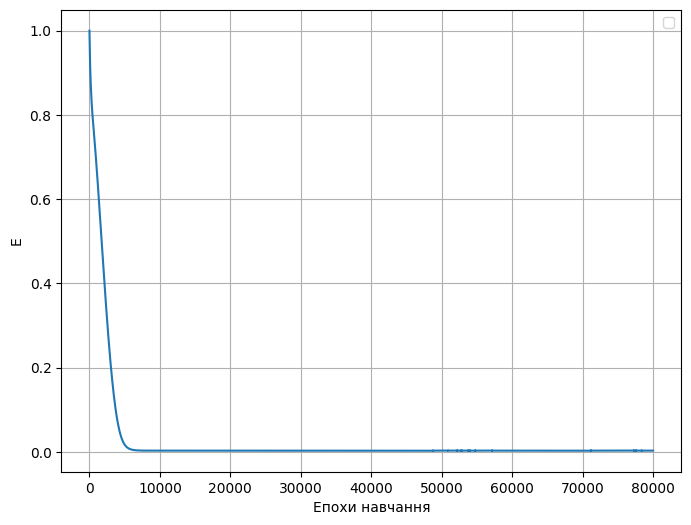

In [ ]:
# Побудова графіку
plt.figure(figsize=(8, 6))    # Розміри графіку (ширина, висота) в дюймах

plt.plot(net_inv.lambda_hist)

# Додавання заголовку, підписів вісей та легенди
# plt.title('Графік декількох кривих')
plt.xlabel('Eпохи навчання')
plt.ylabel('E')
# plt.ylim(0, 1)
plt.legend()   # Виведення легенди з назвами кривих

# Показати графік
plt.grid(True)   # Включити сітку
plt.show()


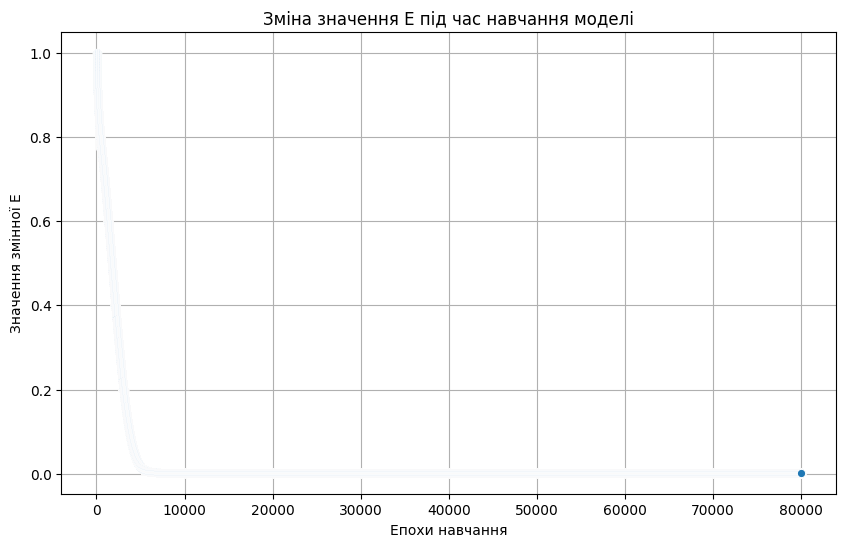

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Дані
epochs = list(range(1, len(net_inv.lambda_hist) + 1))  # Список епох навчання
E_values = net_inv.lambda_hist

# Створення DataFrame для зручності
data = pd.DataFrame({'Епохи': epochs, 'Значення E': E_values})

# Побудова графіку за допомогою Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='Епохи', y='Значення E', marker='o')
plt.xlabel('Епохи навчання')
plt.ylabel('Значення змінної E')
plt.title('Зміна значення E під час навчання моделі')
plt.grid(True)
plt.show()


In [ ]:
import plotly.express as px
import pandas as pd

# Дані
epochs = list(range(1, len(net_inv.lambda_hist) + 1))  # Список епох навчання
E_values = net_inv.lambda_hist

# Створення DataFrame для зручності
data = pd.DataFrame({'Епохи': epochs, 'Значення q/EI': E_values})

# Побудова графіку за допомогою Plotly
fig = px.line(data, x='Епохи', y='Значення q/EI', title='Зміна значення q/EI під час навчання моделі', markers=True)
fig.update_layout(
    # title='Зміна значення E під час навчання моделі'
    title={
        'text': 'Зміна значення q/EI під час навчання моделі',
        'y':0.85,  # Вертикальне позиціонування заголовка
        'x':0.5,  # Горизонтальне вирівнювання по центру
        'xanchor': 'center',  # Центрування по осі x
        'yanchor': 'top',  # Якір для осі y
        'font': {'size':24, 'family':'Arial', 'color':'black'}
    },
    xaxis_title='Епохи навчання',
    yaxis_title='Значення параметра q/EI',
    xaxis=dict(title_font=dict(size=24, family='Arial', color='black')),
    yaxis=dict(title_font=dict(size=24, family='Arial', color='black')),
    font=dict(size=22, family='Arial'),
    template='plotly_white'
)
fig.update_xaxes(tickformat="t")

# Відображення графіку
fig.show()


In [ ]:
net_inv.qEI_true

0.0026659

In [ ]:
net_inv.lambda_hist[-1]

0.002664317176858653

In [ ]:
np.abs(net_inv.qEI_true - net_inv.lambda_hist[-1])/net_inv.qEI_true*100

0.05937293752005539